## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [3]:
data = pd.read_csv('data/ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [4]:
data.info()
# Столбец date имеет тип данных object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [5]:
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')

In [6]:
data_grouped = data.groupby(['date','group']).agg({
    'user_id':'count',
    'purchase':'sum',
    'price': 'sum'
}).reset_index().rename(columns={
    'user_id': 'site_visits',
    'purchase': 'purchases_count',
    'price': 'purchases_sum'
    })

In [7]:
display(data_grouped[['group','date']])
# Тест проводился в период с 02 по 24 января 2021 г.

,group,date
0,A,2021-01-02
1,B,2021-01-02
2,A,2021-01-03
3,B,2021-01-03
4,A,2021-01-04
5,B,2021-01-04
6,A,2021-01-05
7,B,2021-01-05
8,A,2021-01-06
9,B,2021-01-06


## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [8]:
data_grouped['site_visits'][data_grouped['group'] == 'A'].sum()
# Количество посещений сайта в группе A равно 147202

147202

In [9]:
data_grouped['site_visits'][data_grouped['group'] == 'B'].sum()
# Количество посещений сайта в группе B равно 147276

147276

In [10]:
data_grouped['purchases_count'][data_grouped['group'] == 'A'].sum()
# Количество покупок в группе A равно 17723

17723

In [11]:
data_grouped['purchases_count'][data_grouped['group'] == 'B'].sum()
# Количество покупок в группе B равно 17514

17514

In [12]:
data_grouped['purchases_sum'][data_grouped['group'] == 'A'].sum()
# Общая стоимость покупок в группе A составляет 1436.26 млн. рублей

1436260000

In [13]:
data_grouped['purchases_sum'][data_grouped['group'] == 'B'].sum()
# Общая стоимость покупок в группе B составляет 1554.1 млн. рублей

1554100000

## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [14]:
# Создаем множества для каждой группы пользователей
group_a_users = set()
group_b_users = set()

# Добавляем во множество пользователей из группы A
for user in data['user_id'][data['group'] == 'A']:
    group_a_users.add(user)
# Добавляем во множество пользователей из группы B
for user in data['user_id'][data['group'] == 'B']:
    group_b_users.add(user)

# Создае множество с перечением пользователей 
user_intersection = group_a_users.intersection(group_b_users)

In [15]:
len(user_intersection)
# Количество пользователей, попавших в обе группы 1895

1895

## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [16]:
updated_data = data[data['user_id'].apply(lambda x: x not in user_intersection)]

Где user_intersection - множество пересечений пользователей групп А и B.

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

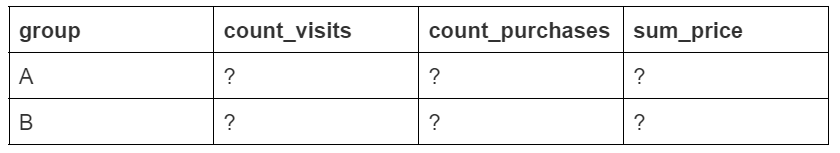
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?


In [17]:
updated_data_grouped = updated_data.groupby('group').agg({
    'user_id': 'count',
    'purchase': 'sum',
    'price': 'sum'
}).rename(columns={
    'user_id': 'count_visits',
    'purchase': 'count_purchases',
    'price': 'sum_price'
})

# Количество посещений сайта равно 145307 для группы A и 145381 для группы B.

Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

Количество посещений сайта для обеих исследуемых групп сопоставимо, 
разница между группами составляет всего лишь 74 посещения, 
что позволяет говорить о сбалансированности выборок.

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [18]:
updated_data_grouped['conversion'] = updated_data_grouped['count_purchases']/updated_data_grouped['count_visits'] * 100
# Конверсия по группе A составляет 12.03%, по группе B - 11.89%.

updated_data_grouped['mean_check'] = updated_data_grouped['sum_price']/updated_data_grouped['count_purchases']
# Средний чек для группы A составляет 81076 рублей, для группы B - 88665 рублей.

Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

По показателю конверсии вариант A на 0.14% процента эффективнее варианта B,
но по среднему чеку вариант B эффективнее варианта A на 7589 рублей.

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [19]:
price_and_group_data = updated_data.pivot_table(
    values='purchase',
    columns='price',
    index='group',
    aggfunc='sum'
)
price_and_group_data.columns = price_and_group_data.columns.astype('string')

Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

Text(0.5, 1.0, 'Тепловая карта продаж туров')

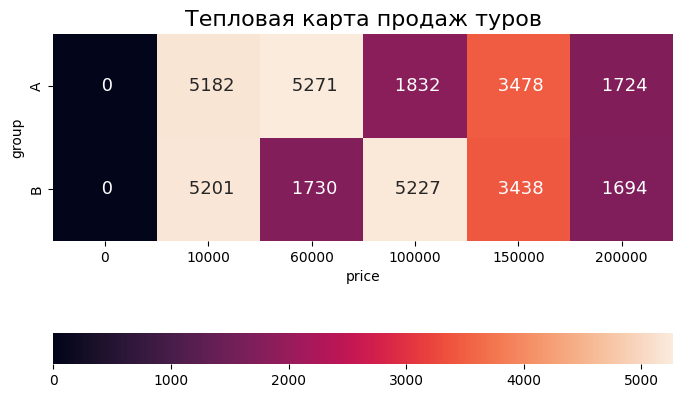

In [20]:
plt.figure(figsize = (8,8))
heatmap = sns.heatmap(data=price_and_group_data, annot=True, fmt=" d", annot_kws={'size':13}, cbar_kws= {'orientation': 'horizontal'}, square=True)
heatmap.set_title('Тепловая карта продаж туров', fontsize=16)
# Количество туров за 60000 рублей по группе A составляет 5271 и по группе B - 1730.

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

У пользователей из группы A выше покупательская способность туров за 60 000 рублей: 5271 туров против 1730.
При этом у пользователей из группы B выше покупательская способность туров за 100 000 рублей: 5227 туров против 1832.

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [21]:
updated_data_ab = updated_data.groupby(['date','group']).agg({
    'user_id': 'count',
    'purchase': 'sum',
    'price': 'sum'
}).reset_index().rename(columns={
    'user_id': 'count_visits',
    'purchase': 'count_purchases',
    'price': 'sum_price'
})

updated_data_ab['conversion'] = updated_data_ab['count_purchases']/updated_data_ab['count_visits'] * 100
updated_data_ab['avg_check'] = updated_data_ab['sum_price']/updated_data_ab['count_purchases']

updated_data_ab['conversion'][updated_data_ab['date'] == '2021-01-03'].round(2)
updated_data_ab['avg_check'][updated_data_ab['date'] == '2021-01-03'].round()
#Конверсия 03 января 2021 г. равна 11.34% для группы A и 11.39% для группы B.
#Средний чек 03 января 2021 г. равен 82888 рублей для группы A и 87480 рублей для группы B.

2    82888.0
3    87480.0
Name: avg_check, dtype: float64

## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [22]:
updated_data_ab['cum_count_visits'] = updated_data_ab.groupby(['group'])['count_visits'].cumsum()
updated_data_ab['cum_count_purchases'] = updated_data_ab.groupby(['group'])['count_purchases'].cumsum()
updated_data_ab['cum_sum_price'] = updated_data_ab.groupby(['group'])['sum_price'].cumsum()
updated_data_ab['cum_conversion'] = updated_data_ab['cum_count_purchases']/updated_data_ab['cum_count_visits'] * 100
updated_data_ab['cum_avg_check'] = updated_data_ab['cum_sum_price']/updated_data_ab['cum_count_purchases']

updated_data_ab['cum_conversion'][((updated_data_ab['date'] == '2021-01-20') & (updated_data_ab['group'] == 'B'))].round(2)
updated_data_ab['cum_avg_check'][((updated_data_ab['date'] == '2021-01-12') & (updated_data_ab['group'] == 'A'))].round()
#Кумулятивная конверсия в группе B на 20 января 2021 г. составляла 11.9%.
#Кумулятивный средний чек в группе A на 12 января 2021 г. был 81 492 рубля.

20    81492.0
Name: cum_avg_check, dtype: float64

Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

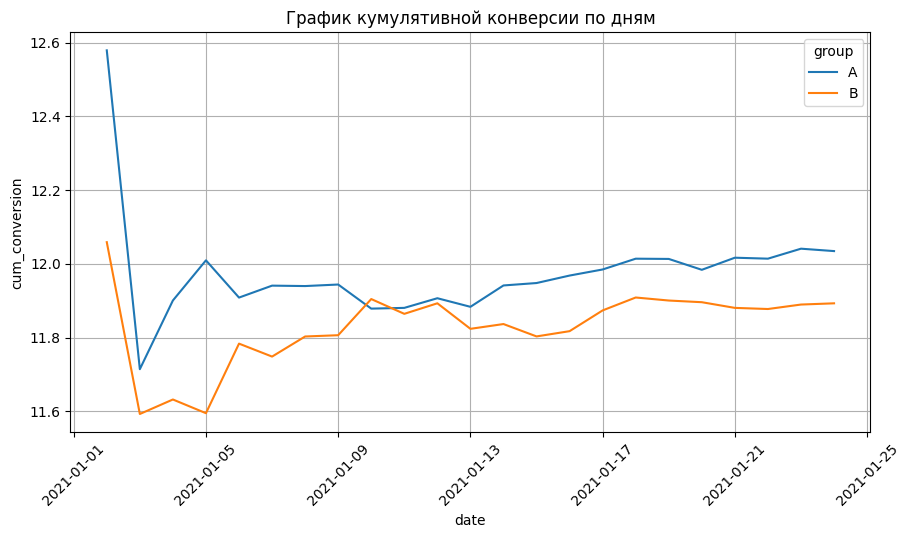

In [23]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([1, 1, 1, 1])
sns.lineplot(x='date', y='cum_conversion', data=updated_data_ab, hue='group', ax=ax)
ax.set_title('График кумулятивной конверсии по дням')
ax.xaxis.set_tick_params(rotation = 45)
ax.grid(True)

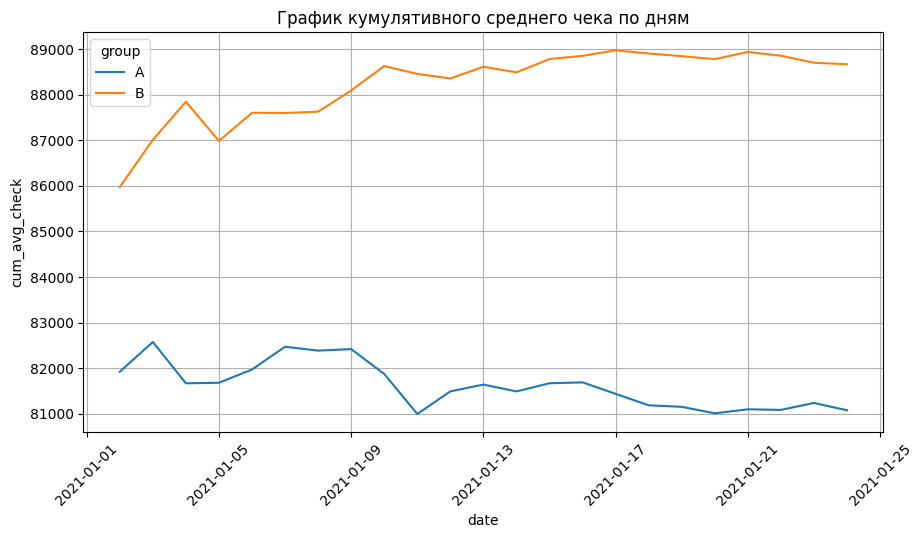

In [24]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([1, 1, 1, 1])
sns.lineplot(x='date', y='cum_avg_check', data=updated_data_ab, hue='group', ax=ax)
ax.set_title('График кумулятивного среднего чека по дням')
ax.xaxis.set_tick_params(rotation = 45)
ax.grid(True)

Начиная с 10 января 2021 г. обе метрики стабилизировались, что говорит о том, 
что A/B тест по состоянию на 24 января 2021 г. можно считать завершенным.
На протяжении всего исследования куммулятивный средний чек в группе B был выше чем в группе A,
но при этом практически все исследование (за исключением 10 января 2021 г.)
куммулятивная конверсия в группе A была выше чем в группе B.
Это соответствует средним значениям данных показателей, которые мы исследовали ранее.

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [25]:
converted_piv = updated_data.groupby('group')['purchase'].agg(
    ['sum', 'count']
)
converted_piv

,sum,count
group,,
A,17487,145307
B,17290,145381


In [26]:
converted_piv = updated_data.groupby('group')['purchase'].agg(
    ['sum', 'count']
)

# выдвигаем нулевую и альтернативную гипотезы
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А больше, чем конверсия в группе B'
alpha = 0.05 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=converted_piv['sum'], #число "успехов"
    nobs=converted_piv['count'], #общее число наблюдений
    alternative='larger',
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value:  0.12
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

МЫ применяем z-тест для проверки гипотезы, поскольку мы проверяем гипотезу равенства пропроций.
Полученное p-value оказывается выше уровня значимости в 5%, в связи с чем мы принимаем нулевую гипотезу.
Это говорит нам о том, что полученная разница в метрике в группах статистически не значима.
Соответственно, по метрике конверсии оба варианта посадочной страницы нашего сайта показывают одинаковую эффективноть.

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [27]:
# фильтруем данные по группам
a_data = updated_data[updated_data['group'] == 'A']
b_data = updated_data[updated_data['group'] == 'B']

# задаем функции для построения интервалов и разницы между ними
def proportions_conf_interval(n, x_p, gamma=0.95):   
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 #погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)


def diff_proportions_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)


conf_interval_a = proportions_conf_interval(
n=a_data['user_id'].count(), # размер выборки
x_p=a_data['purchase'].mean() # выборочная пропорция
)
conf_interval_b = proportions_conf_interval(
n=b_data['user_id'].count(), # размер выборки
x_p=b_data['purchase'].mean() # выборочная пропорция
)
# Доверительный интервал для конверсии группы А: (11.87, 12.2)
# Доверительный интервал для конверсии группы B: (11.73, 12.06)

# размеры выборок групп А и B
n = [a_data['user_id'].count(), b_data['user_id'].count()]
# выборочная пропорция групп A и B
xp = [a_data['purchase'].mean(), b_data['purchase'].mean()]
# строим доверительный интервал для разности конверсий
diff_inverval = diff_proportions_conf_interval(n, xp)
print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval))
# Доверительный интервал для разности конверсий: (-0.38, 0.09)

Доверительный интервал для разности конверсий: (-0.38, 0.09)


Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

Построенные доверительные интервалы для конверсий в группах A и B перекрывают друг друга.
По этой причине, чтобы проверить, есть ли разница в конверсиях, мы построили доверительный интервал для разности.
Доверительный интервал для разности охватывает ноль, что свидетельствует о том, что
варианты посадочной страницы нашего сайта по группам A и B равнозначны по метрике конверсий.

## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

In [30]:
# выдвигаем нулевую и альтернативную гипотезы
H0 = 'Распределения в обеих группах нормальные'
H1 = 'Распределение в одной или обеих группах отлично от нормального'
alpha = 0.05 # уровень значимости
# для проверки гипотезы о нормальности распределения применим тест Шапиро-Уилкаа
shapiro_result_a = shapiro(updated_data_ab['avg_check'][updated_data_ab['group'] == 'A'])
shapiro_result_b = shapiro(updated_data_ab['avg_check'][updated_data_ab['group'] == 'B'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))
# сравниваем полученное p-value с уровнем значимости
if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

# Результаты статистического теста показывают, что для обеих групп
# p-value выше уровня значимости, а значит мы должны принять нулевую гипотезу.
# Это говорит о том, что распределения в обеих группах нормальные.

p-value группы А 0.25
p-value группы B 0.09
Принимаем нулевую гипотезу. Распределения в обеих группах нормальные


## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [31]:
# выдвигаем нулевую и альтернативную гипотезы
H0 = 'Ежедневные средние чеки в группах А и B равны'
H1 = 'Ежедневный средний чек в группе А меньше, чем в группе B'
alpha = 0.05 # уровень значимости
# применяем t-тест для вычисления p-value
results = ttest_ind(
    updated_data_ab['avg_check'][updated_data_ab['group'] == 'A'],
    updated_data_ab['avg_check'][updated_data_ab['group'] == 'B'],
    alternative='less'
)
# выводим результат на экран
print('p-value: ', round(results.pvalue, 2))
# сравниваем полученное p-value с уровнем значимости
if (results.pvalue < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))
    
# Результаты статистического теста показывают, что 
# p-value меньше уровня значимости, а значит мы должны принять альтернативную гипотезу.
# Это говорит о том, что ежедневный средний чек в группе А меньше, чем в группе B.

p-value:  0.0
Отвергаем нулевую гипотезу. Ежедневные средние чеки в группах А и B равны
Альтернативная гипотеза. H1: Ежедневный средний чек в группе А меньше, чем в группе B


 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

Мы используем t-тест, поскольку параметр имеет нормальное распределение, а представленная выборка небольшая - 24 дня.
Проведенный статистический тест показал, что между средними чеками в группах A и B
имеется статистическая разница. Ежедневный средний чек в группе B выше, чем в группе A.

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [33]:
def avg_check_conf_interval(n, x_mean, x_std, gamma=0.95):
    k = n - 1 #число степеней свободы
    alpha = 1 - gamma # уровень значимости
    t_crit = -t.ppf(alpha/2, k) # t критическое
    eps = t_crit * x_std / n**0.5 #погрешность
    lower_bound = x_mean - eps # левая (нижняя) граница
    upper_bound = x_mean + eps # правая (верхняя) граница
    # возвращаем кортеж из округленных границ интервала
    return round(lower_bound), round(upper_bound)
 
a_group_data = updated_data_ab[updated_data_ab['group'] == 'A']
b_group_data = updated_data_ab[updated_data_ab['group'] == 'B']
 
params_a = {
    'n': a_group_data['count_visits'].count(), # размер выборки
    'x_mean': a_group_data['avg_check'].mean(), # выборочное средние
    'x_std': a_group_data['avg_check'].std() # выборочное стандартное отклонения
}
params_b = {
    'n': b_group_data['count_visits'].count(),# размер выборки
    'x_mean': b_group_data['avg_check'].mean(), # выборочное средние
    'x_std': b_group_data['avg_check'].std() # выборочное стандартное отклонения
}
 
print('Доверительный интервал для среднего чека группы А: {}'.format(avg_check_conf_interval(**params_a))) 
print('Доверительный интервал для среднего чека группы B: {}'.format(avg_check_conf_interval(**params_b)))

Доверительный интервал для среднего чека группы А: (79630, 82308)
Доверительный интервал для среднего чека группы B: (87626, 89526)


Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

Между построенными доверительными интервалами для ежедневных средних чеков нет пересечений.
Это говорит о наличии статистической разницы в ежедневных средних чеках.

## **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 

По проверяемым метрикам более эффективным является вариант посадочной страницы, который тестировался на группе пользователей B.
По метрике конверсии оба варианты показывают себя равнозначными, что говорит о том, что дизайн страницы не влияет на вероятность покупки тура пользователем. Однако по метрике среднего чека вариант В показывает себя более эффективным и средний чек для дизайна страницы В выше. По результатам проведенного анализа можно предположить, что это обеспечивается за счет того, что пользователи, использовавшие посадочную страницу с дизайонм В чаще покупали более дорогостоящие туры в Таиланд вместо более дешевых туров в Турцию.